# Лабораторная работа 4
## Линейные модели, SVM и деревья решений.
Цель лабораторной работы: изучение линейных моделей, SVM и деревьев решений.
Выберите набор данных (датасет) для решения задачи классификации или регрессии.
В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
С использованием метода train_test_split разделите выборку на обучающую и тестовую.
Обучите следующие модели:
одну из линейных моделей (линейную или полиномиальную регрессию при решении задачи регрессии, логистическую регрессию при решении задачи классификации);
SVM;
дерево решений.
Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.
Постройте график, показывающий важность признаков в дереве решений.
Визуализируйте дерево решений или выведите правила дерева решений в текстовом виде.

In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, precision_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

target_col='Genres'

%matplotlib inline 
sns.set(style="ticks")

In [144]:
df = pd.read_csv('googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [145]:
# ОЧИЩАЕМ ДАТАСЕТ, КАК В ЛАБ. РАБОТАХ №1 И №"2
# Предположу, что данные версии андроида, обновления и версии нас мало интерисуют, удалим эти столбцы
# удаление столбца
df = df.drop('App', axis=1)
df = df.drop('Android Ver', axis=1)
df = df.drop('Current Ver', axis=1)
df = df.drop('Last Updated', axis=1)

# Как видно, столбец Reviews и прочие имеют тип object, хотя в них числовые значения
# Уберем букву "M", которая обозначает миллион или мегабайт, чтобы остались сухие числа

# удаление строк, содержащих "Varies with device"
df = df[df['Size'] != 'Varies with device']
df = df[df['Price'] != 'Everyone']

# сохранение изменений в исходном файле
#df.to_csv('dfset.csv', index=False)


if df['Size'].dtypes == 'object':
    df['Size'] = df['Size'].str.replace('M', '')
    df['Size'] = df['Size'].str.replace('k', '')
    df['Size'] = df['Size'].str.replace('+', '')
    df['Size'] = df['Size'].str.replace(',', '.')
    df['Size'] = df['Size'].astype(float)

if df['Reviews'].dtypes == 'object':
    df['Reviews'] = df['Reviews'].str.replace('M', '')
    df['Reviews'] = df['Reviews'].astype(int)

if df['Price'].dtypes == 'object':
    df['Price'] = df['Price'].str.replace('$', '')
    df['Price'] = df['Price'].astype(float)
    
if df['Installs'].dtypes == 'object':
    df['Installs'] = df['Installs'].str.replace('M', '')
    df['Installs'] = df['Installs'].str.replace('+', '')
    df['Installs'] = df['Installs'].str.replace(',', '')
    df['Installs'] = df['Installs'].astype(int) # значения в этой колонке слишком большие для float, да и не за чем он тут

if df['Type'].dtypes == 'object':
    df['Type'] = df['Type'].str.replace('Free', 'True') # => True будет значить, что приложение бесплатное 
    df['Type'] = df['Type'].str.replace('Paid', 'False') # => False будет значить, что приложение платное
    df['Type'] = df['Type'].astype(bool)

df = df.dropna()

df = df.drop_duplicates()

# очистили датасет, теперь он готов для построения графиков

In [146]:
df.dtypes

Category           object
Rating            float64
Reviews             int32
Size              float64
Installs            int32
Type                 bool
Price             float64
Content Rating     object
Genres             object
dtype: object

Категориальные признаки

In [147]:
for col in df.columns:
    column_type = df[col].dtype
    if column_type == 'object':
        print(col)

Category
Content Rating
Genres


In [148]:
le1 = LabelEncoder()
df['Category'] = le1.fit_transform(df['Category']);

In [149]:
le2 = LabelEncoder()
df['Content Rating'] = le2.fit_transform(df['Content Rating']);

In [150]:
le3 = LabelEncoder()
df['Genres'] = le3.fit_transform(df['Genres']);

In [151]:
for col in df.columns:
    column_type = df[col].dtype
    if column_type == 'object':
        print(col)

## Разделение выборки на обучающую и тестовую


In [152]:
# Разделяем данные на две переменные: признаки (X) и целевую переменную (Y)
X = df.drop(target_col, axis=1)
Y = df[target_col]

In [153]:
X

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating
0,0,4.1,159,19.0,10000,True,0.0,1
1,0,3.9,967,14.0,500000,True,0.0,1
2,0,4.7,87510,8.7,5000000,True,0.0,1
3,0,4.5,215644,25.0,50000000,True,0.0,4
4,0,4.3,967,2.8,100000,True,0.0,1
...,...,...,...,...,...,...,...,...
10833,3,4.8,44,619.0,1000,True,0.0,1
10834,11,4.0,7,2.6,500,True,0.0,1
10836,11,4.5,38,53.0,5000,True,0.0,1
10837,11,5.0,4,3.6,100,True,0.0,1


In [154]:
Y

0         9
1        11
2         9
3         9
4        10
         ..
10833    18
10834    36
10836    36
10837    36
10840    64
Name: Genres, Length: 7420, dtype: int32

In [155]:
pd.DataFrame(X, columns=X.columns).describe()

,Category,Rating,Reviews,Size,Installs,Price,Content Rating
count,7420.000000,7420.000000,7.420000e+03,7420.000000,7.420000e+03,7420.000000,7420.000000
mean,16.580458,4.171321,2.788920e+05,37.581119,7.825292e+06,1.117201,1.466442
std,8.138965,0.549847,1.744084e+06,94.987170,4.631642e+07,17.713320,1.006693
min,0.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000
25%,11.000000,4.000000,9.900000e+01,5.900000,1.000000e+04,0.000000,1.000000
50%,14.000000,4.300000,2.066500e+03,16.000000,1.000000e+05,0.000000,1.000000
75%,24.000000,4.500000,3.688325e+04,37.000000,1.000000e+06,0.000000,1.000000
max,32.000000,5.000000,4.489389e+07,994.000000,1.000000e+09,400.000000,5.000000


Разделим выборку на обучающую и тестовую:

In [156]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
print('{}, {}'.format(X_train.shape, X_test.shape))
print('{}, {}'.format(Y_train.shape, Y_test.shape))

(5565, 8), (1855, 8)
(5565,), (1855,)


## Обучение моделей

### Линейная модель

In [157]:
# SGDClassifier - это классификатор, основанный на стохастическом градиентном спуске (Stochastic Gradient Descent). 
# max_iter=10000 - это параметр, который указывает максимальное количество итераций для обучения модели.

SGD = SGDClassifier(max_iter=10000)
SGD.fit(X_train, Y_train)

# модель SGD  обучена на обучающих данных и может быть использована для предсказания целевой переменной для новых данных.

c:\Users\mesou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=10000)

In [158]:
# вычисляем F1-оценку для предсказаний модели на тестовых данных
f1_score(Y_test, SGD.predict(X_test), average='micro')
# вычисляем оценку точности для предсказаний модели на тестовых данных
precision_score(Y_test, SGD.predict(X_test), average='micro')

0.00646900269541779

### SVM

In [159]:
SVC = SVC(kernel='rbf')
SVC.fit(X_train, Y_train)

SVC()

In [160]:
f1_score(Y_test, SVC.predict(X_test), average='micro')
precision_score(Y_test, SVC.predict(X_test), average='micro')

0.09218328840970351

### Дерево решений

In [161]:
DT = DecisionTreeClassifier(random_state=1)
DT.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=1)

In [162]:
f1_score(Y_test, DT.predict(X_test), average='micro')
precision_score(Y_test, DT.predict(X_test), average='micro')

0.7498652291105121

Можно сделать вывод, что дерево решений дает лучший результат

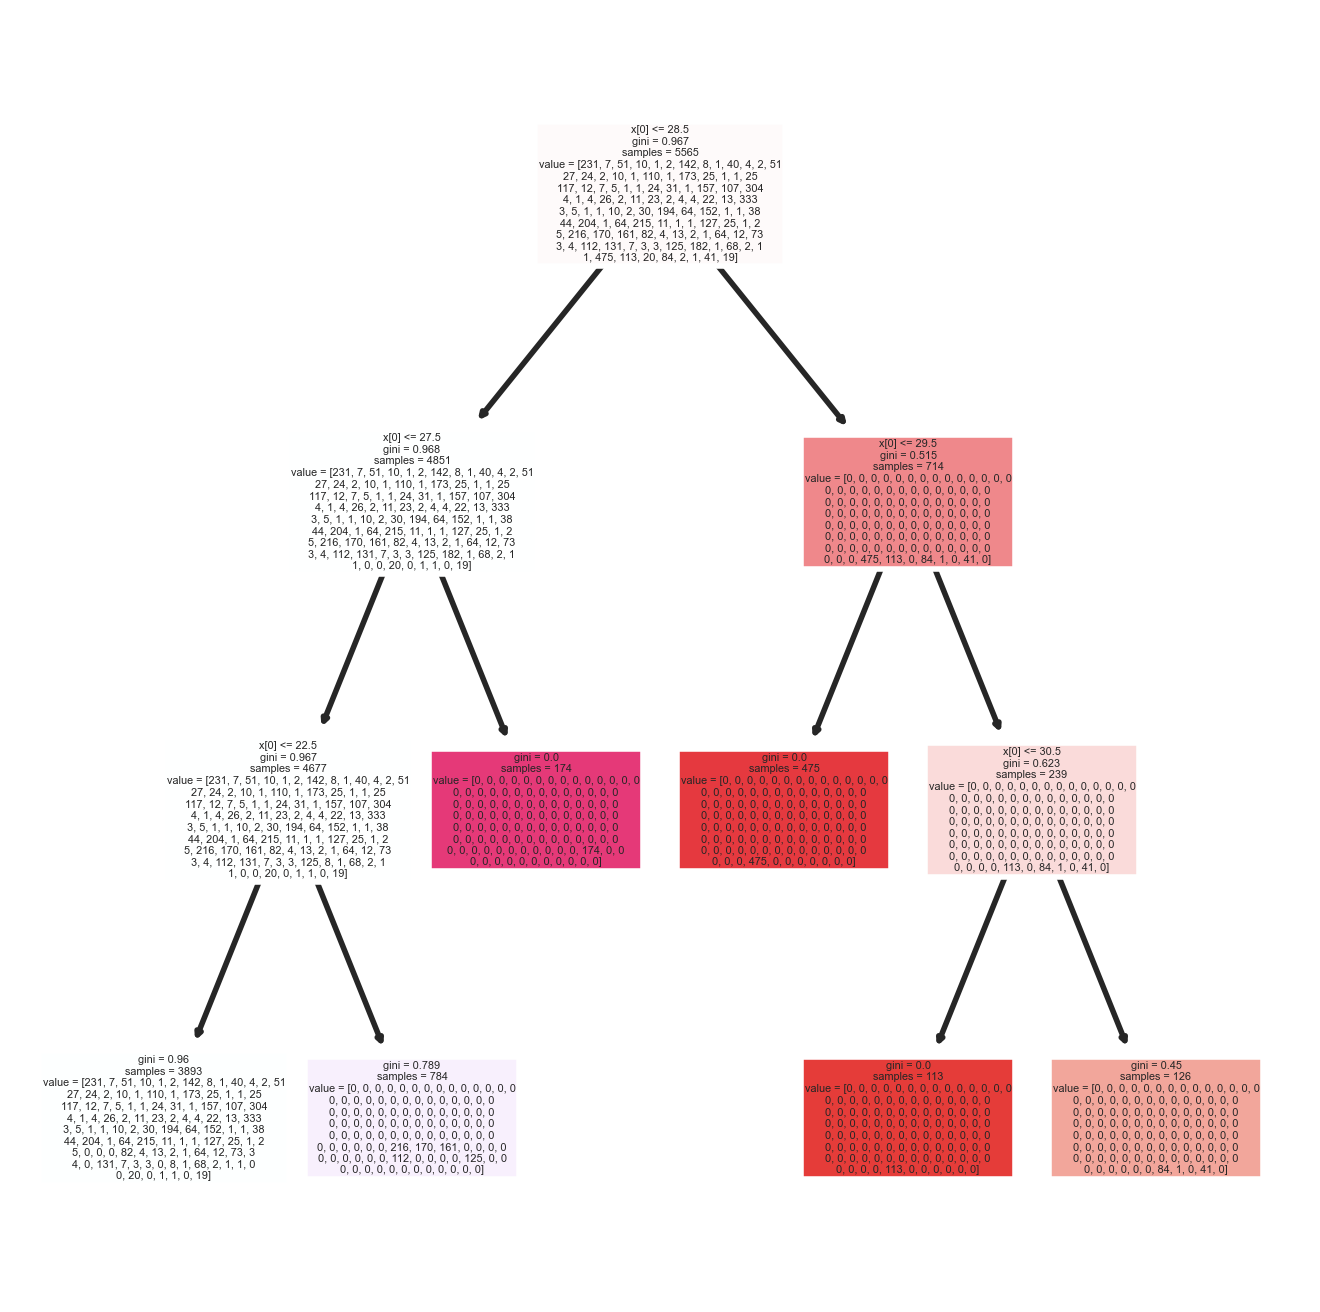

In [163]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=400)
clf = DecisionTreeClassifier(max_depth = 3, 
                             random_state = 0)
clf.fit(X_train, Y_train)
tree.plot_tree(clf, filled = True);